Your Name and PRN:
- Name: Rajesh Singh
- PRN : 240840128028
- Date: 29/11/2024

# Image Processing with Neural Network

## Assignment A06 :
## Working with PyTorch
- Custom DataSet with common transformation
- Activation function of your choice
- Regularization:
    - L2,
    - BatchNorm,
    - Dropout,
    - Early Stopping.
    
- multi-class output
- Fashion MNIST dataset

$$\Large\textbf{
   Imporint the Libraries 
}$$

In [1]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


In [2]:
import warnings
warnings.filterwarnings('ignore')

$$\Large\textbf{
   Defining Global Variables 
}$$

In [3]:
# Global variables
inpDir = '../input' # Input Stored here
outDir = '../ouput' # output Here
modelDir = '../models'# to save Models
subDir = 'fashion_mnist' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 101
BATCH_SIZE = 32
LR_FACTOR=0.1
LR_PATIENCE=10
EARLY_STOPPING_PATIENCE = 15  # Patience for early stopping
WEIGHT_DECAY = 0.001


In [4]:
#set the plotting parameters
params = {
    'legend.fontsize': 'medium',
    'figure.figsize':(15,4),
    'axes.labelsize':'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'medium',
    #'text.usetex':True,
}
plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


$$\Large\textbf{
   Funtion to plot training history
}$$

In [5]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()



$$\Large\textbf{
    Loading MNIST Fashion dataset
}$$

In [6]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
valid_df = pd.read_csv(valid_filename, header = 0)


train_df.shape, valid_df.shape

((60000, 785), (10000, 785))

$$\Large\textbf{
   Basic EDA 
}$$

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
for col in train_df.columns:
    unq = train_df[col].unique()
    print(f'{col}, #:{len(unq)}, Values:{unq}')

label, #:10, Values:[2 9 6 0 3 4 5 8 7 1]
pixel1, #:8, Values:[ 0 14  7  3 16  1  4  2]
pixel2, #:17, Values:[ 0  1  3 10  6  2  7  5 16 14 13  9 34 15  4 11 36]
pixel3, #:27, Values:[  0   2   1  10   3   6   4   5   7  56  34  32  16  14  78  25  13   9
   8  52  35  30  23  54 226  15 106]
pixel4, #:65, Values:[  0   1   5   2   3  20  46  87   4  16  12   6  64  36  52  13   7 164
 110  14  92 106 120 105  53  70   9  23  49  25  26  34 121  21  17  10
  41  18  28  80  56 144  22  54  55  50  90 150  19 109  83 132  48  11
  32 145  39  96  15  58   8  68  82 146  86]
pixel5, #:103, Values:[  0   2   4   1   5   3  26  14  39  62  15  16  84   7  88  41  65  17
  35  61  11  21  10   6  18 119 162 106  34  12 217  33  24  37  13 185
  38  71  73   9  40  56  68 171  89  97  91  23  59  42  77 103  29 148
 140  31  45 201   8  95 133  80  44  43  27  20  32  58 123  22 116  66
  60  53 145  85 100  54 210 166 113  19  28 227  30  51  64  96  75  70
  90  82 115 153  36 169  92 110 

In [9]:
train_df.columns[-10:]

Index(['pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object')

In [10]:
# data_df.dropna(subset= ('Position'), inplace = True)
train_df.isna().sum().sum()

0

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [12]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [13]:
class_names = {
    0: 'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8:'Bag', 
    9: 'Ankle boot'
}

$$\Large\textbf{
   Plotting Images 
}$$

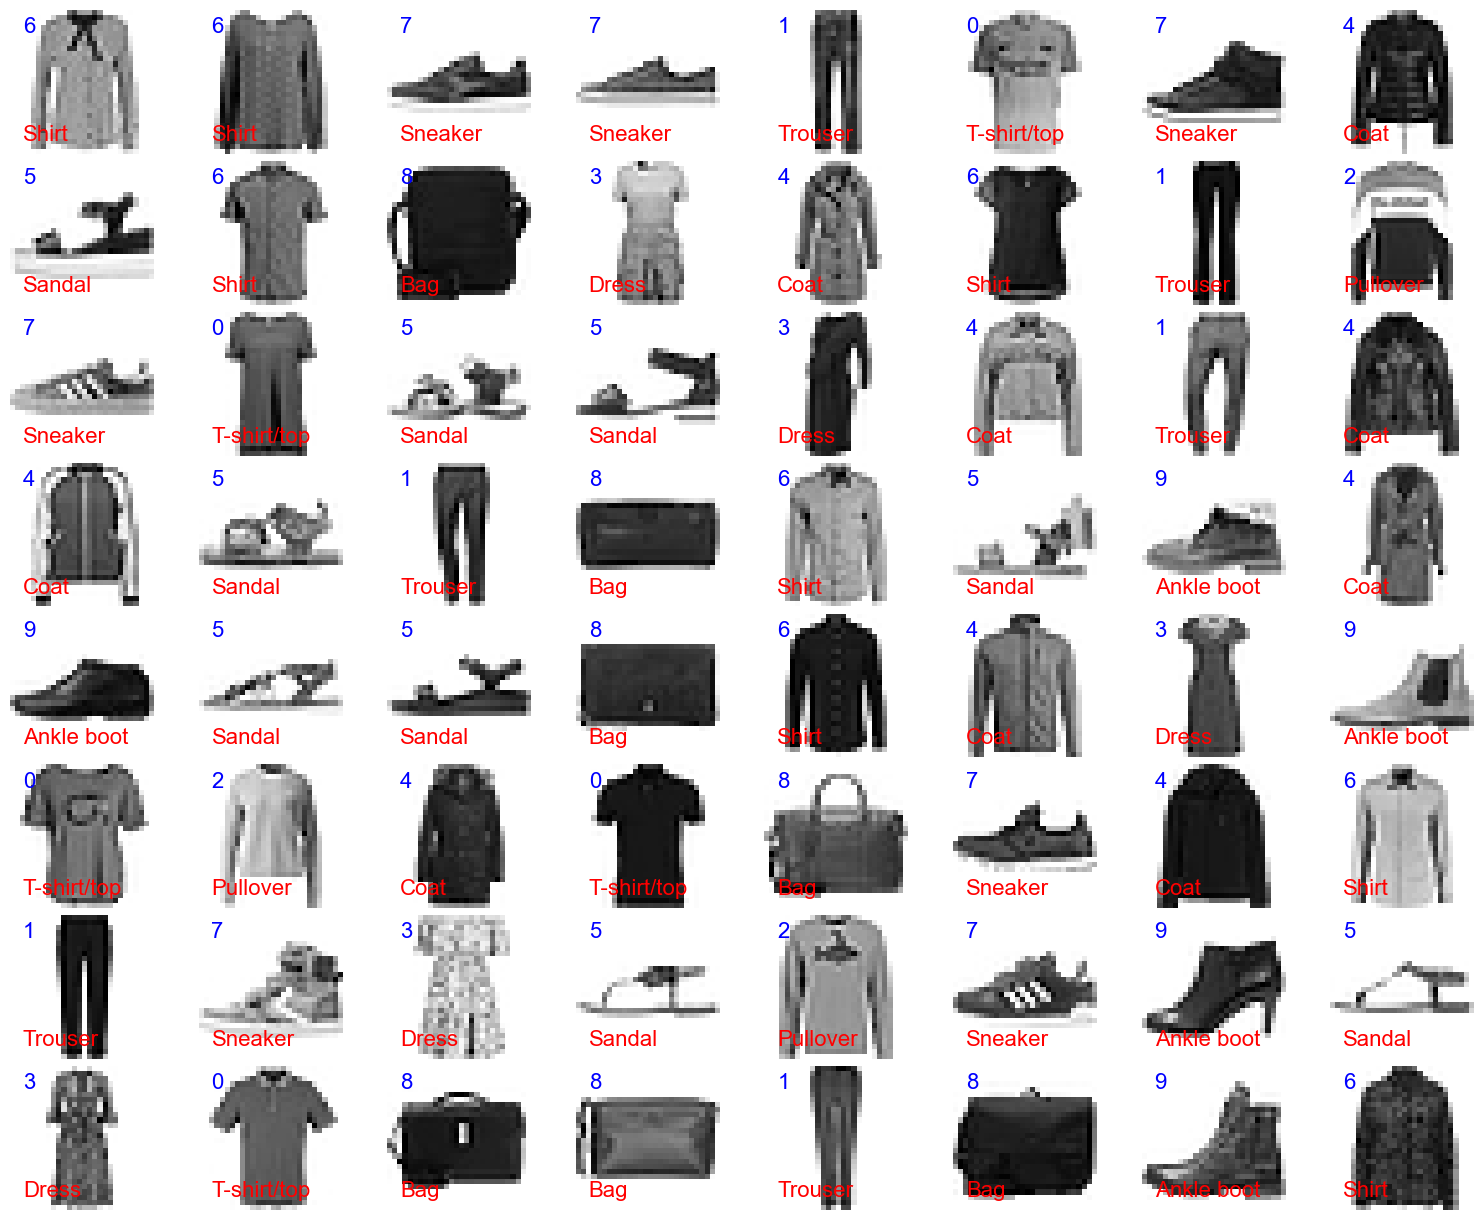

In [14]:
# sample data plot: Display a grid of images from the dataset along with their labels

n_rows =  8 # Number of rows to display in the grid
n_cols = 8 # Number of columns

# randomly sample 'n_rows' * n_cols images from the dataset
plot_df = train_df.sample(n = n_rows * n_cols)

#create a new figure for the grid of images with a specified size
fig = plt.figure(figsize  =(15,12))

#Adjust Margins
fig.subplots_adjust(left = 0, right = 1, bottom=0, top = 1, hspace =0.05, wspace = 0.05)
i= 0 
for idx, row in plot_df.iterrows():
    i += 1
    image = row.values[1:].reshape(28,28)
    ax = fig.add_subplot(n_rows, n_cols, i, xticks=[], yticks=[])
    #Display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = 'nearest')
    ax.text(2,4, str(row.iloc[0]), color = 'b', fontsize=16)
    ax.text(2,25, class_names[row.iloc[0]], color='r', fontsize  = 16)
plt.show()

$$\Large\textbf{
    Extracting and Split Data in test train
    
}$$

In [15]:
X = train_df.drop('label',axis=1)
y = train_df['label'].to_numpy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    stratify=y, 
    random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 784), (12000, 784), (48000,), (12000,))

In [17]:
X_valid = valid_df.drop('label', axis=1).to_numpy()
y_valid = valid_df['label'].to_numpy()

In [18]:
type(X_train), type(X_test), type(y_train), type(y_test), type(X_valid), type(y_valid)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

$$\Large\textbf{
   Normalizing the data
}$$

In [19]:
# Normalize data beetween [0-1]
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

In [20]:
X_train.shape

(48000, 784)

$$\Large\textbf{
    Defining the Custom Dataset Class 
}$$

In [21]:
'''Define custom dataset'''
class MnistDataset(Dataset):
    def __init__(self, X, y):
        super(MnistDataset, self).__init__()
        self.X = torch.tensor(X.to_numpy(), dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)
        
    def __len__(self): # length of the data = noumber of rows 
        return(len(self.X))

    def __getitem__(self, idx): # give me index of X , y
        return self.X[idx], self.y[idx]
    

$$\Large\textbf{
    Loaiding the Train, Test data using Custom class     
}$$

In [22]:
train_dataset = MnistDataset(X_train, y_train)
train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True
)
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

In [23]:
test_dataset = MnistDataset(X_test, y_test)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
X_batch, y_batch = next(iter(test_loader))
X_batch.shape, y_batch.shape

$$\Large\textbf{
    Checking GPU Availability
}$$

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

$$\Large\textbf{
   Defining the model 
}$$

In [30]:
X_train.shape[1]

784

In [31]:
input_dim = X_train.shape[1]

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()

        # Set 1
        dor1 = 0.2
        self.layer1 = nn.Linear(input_dim, 392)
        self.bn1 = nn.BatchNorm1d(392) # Size same as from layer1
        self.actv1 = nn.ReLU()
        self.do1 = nn.Dropout(dor1)
        
        # Set 2
        dor2 = 0.3
        self.layer2 = nn.Linear(392, 196)
        self.bn2 = nn.BatchNorm1d(196) # Size same as o/p from layer2
        self.actv2 = nn.ReLU()
        self.do2 = nn.Dropout(dor2)
        
        # Set 3
        dor3 = 0.4
        self.layer3 = nn.Linear(196, 98)
        self.bn3 = nn.BatchNorm1d(98) # Size same as o/p from layer3
        self.actv3 = nn.ReLU()
        self.do3 = nn.Dropout(dor3)
        
        # Set 4
        dor4 = 0.5
        self.layer4 = nn.Linear(98, 10)
        self.bn4 = nn.BatchNorm1d(10) # Size same as o/p from layer4
        self.actv4 = nn.ReLU()
        self.do4 = nn.Dropout(dor4)

        # Set 5
        self.layer5 = nn.Linear(10, 10)



    def forward(self, x):
        # Set 1
        x = self.layer1(x)
        x = self.bn1(x)     # Batch Norm
        x = self.actv1(x)
        x = self.do1(x)

        # Set 2
        x = self.layer2(x)
        x = self.bn2(x)     # Batch Norm
        x = self.actv2(x)
        x = self.do2(x)

        # Set 3
        x = self.layer3(x)
        x = self.bn3(x)     # Batch Norm
        x = self.actv3(x)
        x = self.do3(x)

        # Set 4
        x = self.layer4(x)
        x = self.bn4(x)     # Batch Norm
        x = self.actv4(x)
        x = self.do4(x)

        # Set 5
        x = self.layer5(x)
        
        return x


In [32]:
model = Model(input_dim).to(device=device)

Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.4, inplace=False)
  (bn3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=98, out_features=10, bias=True)
  (actv4): ReLU()
  (do4): Dropout(p=0.5, inplace=False)
  (bn4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=10, out_features=10, bias=True)
)


In [33]:
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 392]         307,720
       BatchNorm1d-2                  [-1, 392]             784
              ReLU-3                  [-1, 392]               0
           Dropout-4                  [-1, 392]               0
            Linear-5                  [-1, 196]          77,028
       BatchNorm1d-6                  [-1, 196]             392
              ReLU-7                  [-1, 196]               0
           Dropout-8                  [-1, 196]               0
            Linear-9                   [-1, 98]          19,306
      BatchNorm1d-10                   [-1, 98]             196
             ReLU-11                   [-1, 98]               0
          Dropout-12                   [-1, 98]               0
           Linear-13                   [-1, 10]             990
      BatchNorm1d-14                   

$$\Large\textbf{
    Creating the model saving path 
}$$

In [34]:
model_path = os.path.join(modelDir, subDir, f'torch_Mnist_regularized_{torch.version.cuda}.pth')
model_path

'../models\\fashion_mnist\\torch_Mnist_None.pth'

$$\Large\textbf{
   Traingin the MNIST Fashion Classification Model
}$$

In [35]:
#Loss function
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA, weight_decay=WEIGHT_DECAY)

# If modell not improving after no. of epochs reduce LR with LR_FACTOR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr=1e-5
)
# always need to write 
# some lists to collect progress
loss, tloss, n_epoch, acc, tacc = [], [], [], [], []

best_loss = np.inf

# loop for definedd epochs
for epoch in range(EPOCHS):
    model.train() # set model in training mode 
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
   
    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X = train_X.to(device) # move data to device
        train_y = train_y.to(device)  # move data to device
        predict_proba = model(train_X)  # make prediction
        batch_loss = loss_fn(predict_proba, train_y)  # calculate loss
        epoch_loss += (batch_loss - epoch_loss) / (batch_idx+1) #   calculate running mean -> batch loss for each batch -> then calculate avg loss for epoch
        optimizer.zero_grad() # Gradient set to Zero
        batch_loss.backward() # calculate loss in backpropagation
        optimizer.step() # move with the steps given by optimizer
        y_pred = predict_proba.argmax(dim=1).cpu().numpy() # make prediction
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred) # calculate accuracy
        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    # set model in eval mode for test
    model.eval()
    for batch_idx, (test_X, test_y) in enumerate(test_loader):
        test_X, test_y = test_X.to(device), test_y.to(device) # move data to device
        test_proba = model(test_X)  # make prediction
        batch_loss = loss_fn(test_proba, test_y)    # calculate loss
        tepoch_loss += (batch_loss - tepoch_loss)/ (batch_idx + 1)  # calculate running mean -> batch loss for each batch -> then calculate avg loss for epoch
        y_pred =test_proba.argmax(dim=1).cpu().numpy()  # make prediction
        batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)    # calculate accuracy
        tepoch_acc += (batch_acc - tepoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item())
    n_epoch.append(epoch)


    # Save model if test loss is lower than best loss
    if tepoch_loss < best_loss:
        best_loss = tepoch_loss
        torch.save(model,model_path)

    #LR Reduction step
    scheduler.step(tepoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch:{epoch:>5d} | Loss: {epoch_loss:0.5f}/{tepoch_loss:0.5f}| Accuracy: {epoch_acc:0.5f}/{tepoch_acc:0.5f}')
        print(f'Acc: {epoch_acc: .5f}/{tepoch_acc: .5f}')
        print(f'LR: {scheduler.get_last_lr()[0]: .5f}')
    

Epoch:    0 | Loss: 1.35823/0.62239| Accuracy: 0.50079/0.82600
Acc:  0.50079/ 0.82600
LR:  0.00100
Epoch:   10 | Loss: 0.90003/0.40530| Accuracy: 0.66388/0.87517
Acc:  0.66388/ 0.87517
LR:  0.00100
Epoch:   20 | Loss: 0.85274/0.37897| Accuracy: 0.68085/0.88050
Acc:  0.68085/ 0.88050
LR:  0.00100
Epoch:   30 | Loss: 0.80943/0.37500| Accuracy: 0.70346/0.88558
Acc:  0.70346/ 0.88558
LR:  0.00100
Epoch:   40 | Loss: 0.77970/0.37048| Accuracy: 0.71144/0.88675
Acc:  0.71144/ 0.88675
LR:  0.00100
Epoch:   50 | Loss: 0.76057/0.36229| Accuracy: 0.72094/0.88850
Acc:  0.72094/ 0.88850
LR:  0.00100
Epoch:   60 | Loss: 0.71105/0.35181| Accuracy: 0.73710/0.89533
Acc:  0.73710/ 0.89533
LR:  0.00010
Epoch:   70 | Loss: 0.69973/0.35501| Accuracy: 0.74206/0.89983
Acc:  0.74206/ 0.89983
LR:  0.00010
Epoch:   80 | Loss: 0.68112/0.35011| Accuracy: 0.74919/0.90000
Acc:  0.74919/ 0.90000
LR:  0.00010
Epoch:   90 | Loss: 0.68655/0.34615| Accuracy: 0.74840/0.89525
Acc:  0.74840/ 0.89525
LR:  0.00001
Epoch:  10

$$\Large\textbf{
   Creating the Datarame  of History
}$$

In [36]:
loss_df = pd.DataFrame({
    'epoch':n_epoch ,
    'loss':loss,
    'test_loss':tloss,
    'acc':acc,
    'test_acc':tacc
})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.358232,0.622387,0.500792,0.826000
1,1,1.117743,0.545686,0.582542,0.836917
2,2,1.064693,0.518218,0.608792,0.852417
3,3,1.029892,0.471599,0.615396,0.854167
4,4,1.009082,0.470797,0.623729,0.857917


$$\Large\textbf{
   Plotting Loss and Accuracy
}$$

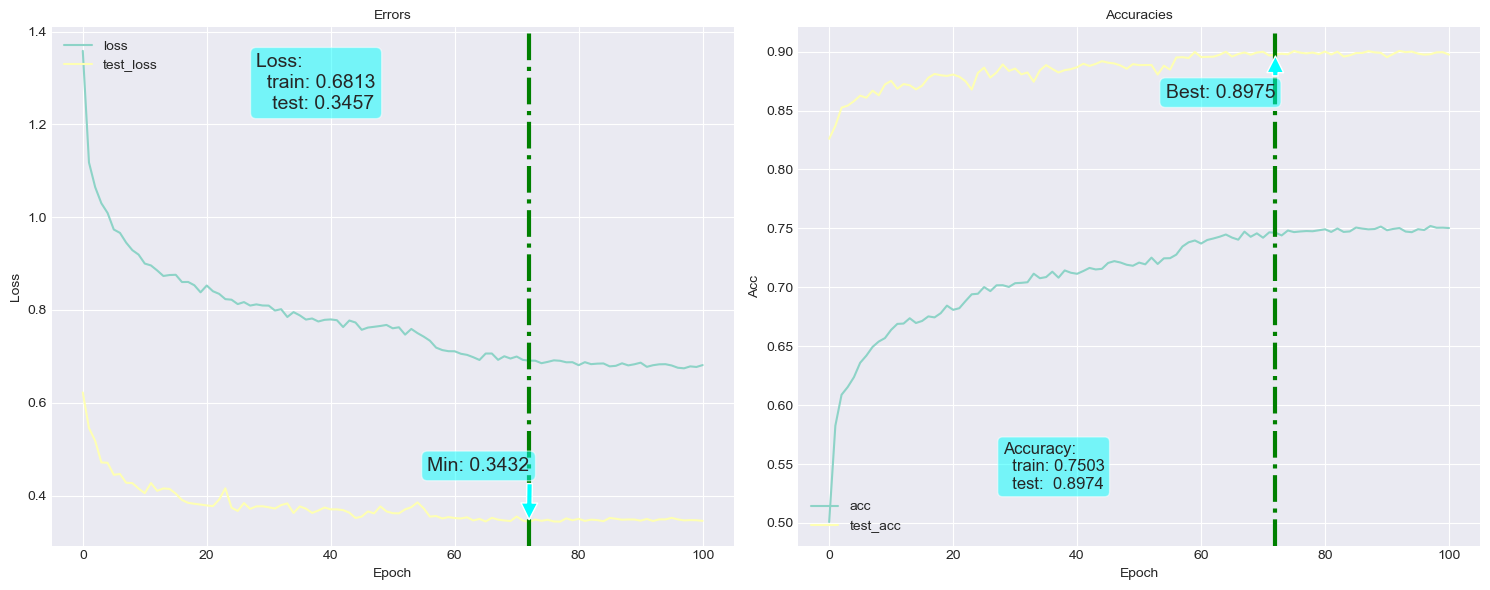

In [37]:
fn_plot_torch_hist(hist_df=loss_df)

$$\Large\textbf{
   Testing on Training Data
}$$

torch.Size([32, 10])
[4 5 2 9 9 7 9 2 0 9 1 4 7 4 6 3 7 8 9 1 1 7 7 3 3 1 3 0 4 4 0 6]
Accuracy:  96.875
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         5

    accuracy                           0.97        32
   macro avg       0.95      0.97      0.95        32
weighted avg       0.98      0.97      0.97        32



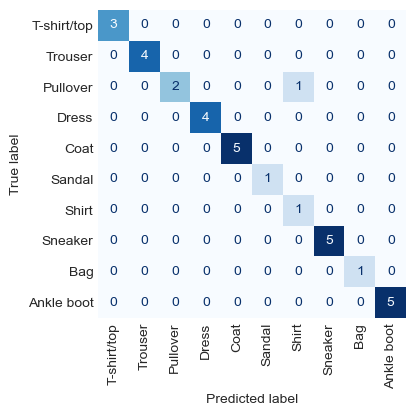

In [49]:
outputs = model(train_X)
print(outputs.shape)


y_pred = torch.argmax(outputs, dim=1).cpu().numpy() #outputs.cpu().detach().numpy()
print(y_pred)


y_true = train_y.cpu().numpy()
print('Accuracy: ',accuracy_score(y_true, y_pred)*100)
print('Classification Report')
print(classification_report(y_true, y_pred))

# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names.values())

disp.plot(cmap= 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)

torch.Size([32, 10])
[7 8 9 0 9 0 2 5 0 3 1 8 0 9 9 1 3 2 7 6 2 6 4 4 4 9 9 9 1 3 0 1]
Accuracy:  84.375
Classification Report
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         3
           3       0.33      0.50      0.40         2
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         1
           6       1.00      0.50      0.67         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         7

    accuracy                           0.84        32
   macro avg       0.87      0.86      0.84        32
weighted avg       0.92      0.84      0.86        32



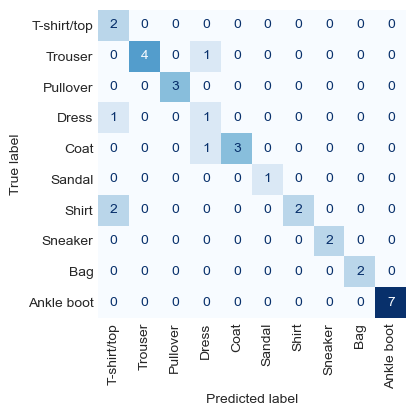

In [50]:
outputs = model(test_X)
print(outputs.shape)


y_pred = torch.argmax(outputs, dim=1).cpu().numpy() #outputs.cpu().detach().numpy()
print(y_pred)


y_true = test_y.cpu().numpy()

print('Accuracy: ',accuracy_score(y_true, y_pred)*100)
print('Classification Report')
print(classification_report(y_true, y_pred))

# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names.values())

disp.plot(cmap= 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)

$$\Large\textbf{
   Testing saved model 
}$$

torch.Size([32, 10])
[7 8 9 0 9 0 2 5 0 3 1 8 0 9 9 1 3 2 7 2 2 6 4 4 4 9 9 9 1 3 0 1]
Accuracy:  81.25
Classification Report
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.80      0.89         5
           2       0.75      1.00      0.86         3
           3       0.33      0.50      0.40         2
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         1
           6       1.00      0.25      0.40         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         7

    accuracy                           0.81        32
   macro avg       0.85      0.83      0.80        32
weighted avg       0.90      0.81      0.81        32



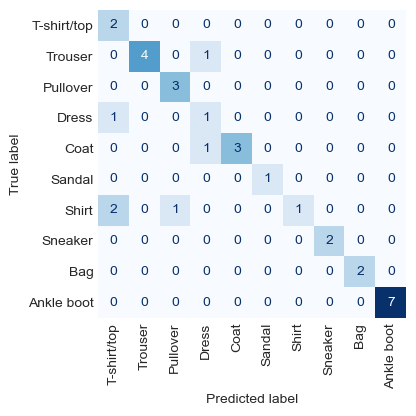

In [62]:
# Loadin the model
model1 = torch.load(model_path, weights_only = False)


# Predictions
outputs = model1(test_X)
print(outputs.shape)

# Argmax for predictions
y_pred = torch.argmax(outputs, dim=1).cpu().numpy() #outputs.cpu().detach().numpy()
print(y_pred)

# True Labels
y_true = test_y.cpu().numpy()

print('Accuracy: ',accuracy_score(y_true, y_pred)*100)
print('Classification Report')
print(classification_report(y_true, y_pred))

# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names.values())

disp.plot(cmap= 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)